# BQ: Can we utilize the Cartesian coordinates of players on the field as a proxy for "tiredness" to advantage the run?

In [227]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
import math

In [182]:
tracking_files = glob.glob("data/tracking_week_*.csv")
tracking_data = pl.concat([pl.read_csv(f, null_values= ["NA"]) for f in tracking_files])
plays = pl.read_csv("data/plays.csv", null_values=["NA"])
players = pl.read_csv("data/players.csv", null_values=["NA"])

In [3]:
test_game = tracking_data.filter(
    (pl.col("gameId") == 2022102700)
)

In [4]:
test_game['playId'].unique()

playId
i64
68
97
121
150
201
…
4183
4205
4227


In [7]:
first_play = test_game.filter(
    (pl.col("playId") == 68)
)

In [9]:
first_play['displayName'].unique()

displayName
str
"""Patrick Ricard"""
"""football"""
"""Vita Vea"""
"""Kevin Zeitler"""
"""Devin White"""
…
"""Ronnie Stanley"""
"""Rashod Bateman"""
"""Kenyan Drake"""


In [220]:
single_player = test_game.filter(
    (pl.col("displayName") == "Vita Vea")
)
single_player = single_player.join(plays, on= ["playId"])
single_player = single_player.join(players, on=["nflId"])

In [232]:
idx = 0
grouped_data = single_player.group_by("playId", maintain_order=True).agg(
    pl.col("a").max().alias("max_a"),
    pl.col("time").first().alias("time"),
    pl.col("displayName").first(),
    pl.col("quarter").first(),
    pl.col("weight").first(),
    pl.col("position").first(),
    pl.col("gameClock").first()
)

grouped_data = grouped_data.with_columns(
    (pl.col("weight") * pl.col("max_a")).alias("Newtons")
)

grouped_data = grouped_data.sort("time")
grouped_data = grouped_data.with_columns(
    pl.arange(0, grouped_data.height, eager=True).alias("play")
)
grouped_data = grouped_data.with_columns(
    (
        (pl.col("quarter").cast(pl.Utf8) + "." + pl.col("play").cast(pl.Utf8))
        .cast(pl.Float64)
    ).alias("quarter_play")
)
grouped_data

playId,max_a,time,displayName,quarter,weight,position,gameClock,Newtons,play,quarter_play
i64,f64,str,str,i64,i64,str,str,f64,i64,f64
68,3.51,"""2022-10-28 00:16:19.3""","""Vita Vea""",1,347,"""NT""","""14:56""",1217.97,0,1.0
97,4.21,"""2022-10-28 00:17:06""","""Vita Vea""",1,347,"""NT""","""13:51""",1460.87,1,1.1
121,2.83,"""2022-10-28 00:17:47.1""","""Vita Vea""",1,347,"""NT""","""13:49""",982.01,2,1.2
150,3.6,"""2022-10-28 00:18:37.7""","""Vita Vea""",1,347,"""NT""","""13:17""",1249.2,3,1.3
549,4.7,"""2022-10-28 00:36:08""","""Vita Vea""",1,347,"""NT""","""06:55""",1630.9,4,1.4
…,…,…,…,…,…,…,…,…,…,…
3259,3.84,"""2022-10-28 02:43:36""","""Vita Vea""",4,347,"""NT""","""08:48""",1332.48,38,4.38
3764,2.43,"""2022-10-28 03:01:56.5""","""Vita Vea""",4,347,"""NT""","""03:40""",843.21,39,4.39
3785,3.46,"""2022-10-28 03:02:45.8""","""Vita Vea""",4,347,"""NT""","""02:54""",1200.62,40,4.4


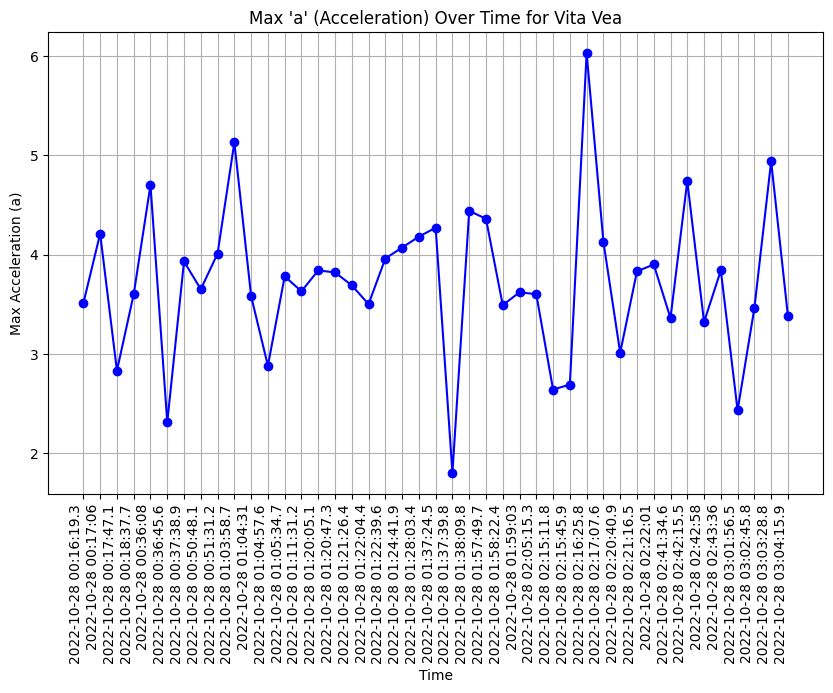

In [233]:
# Plot max 's' over time
plt.figure(figsize=(10, 6))
plt.plot(grouped_data["time"], grouped_data["max_a"], marker='o', linestyle='-', color='blue')
plt.title(f"Max 'a' (Acceleration) Over Time for {grouped_data['displayName'].first()}")
plt.xlabel("Time")
plt.xticks(rotation=90, ha='right')
plt.ylabel("Max Acceleration (a)")
plt.grid(True)
plt.show()

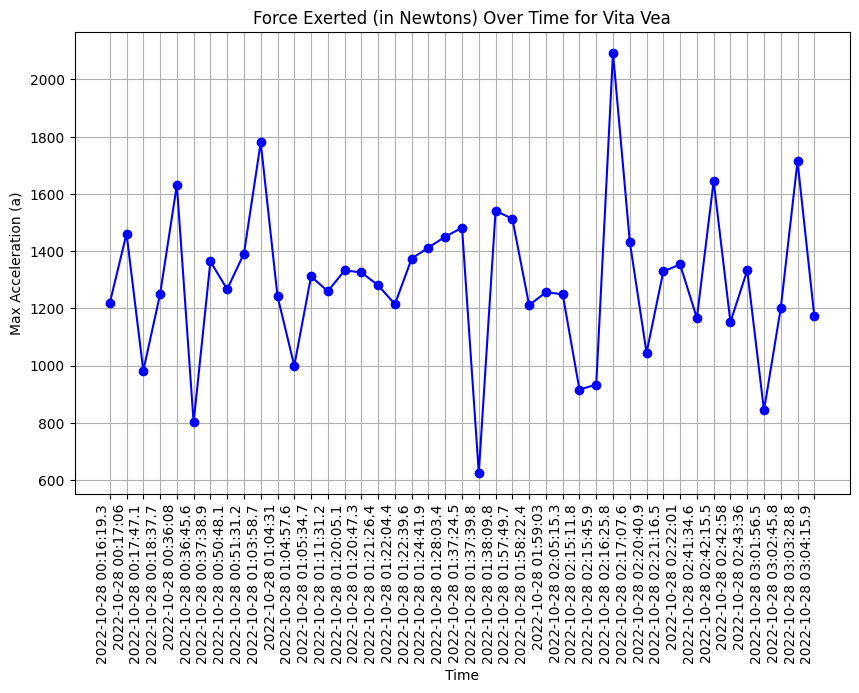

In [234]:
# Plot max 's' over time
plt.figure(figsize=(10, 6))
plt.plot(grouped_data["time"], grouped_data["Newtons"], marker='o', linestyle='-', color='blue')
plt.title(f"Force Exerted (in Newtons) Over Time for {grouped_data['displayName'].first()}")
plt.xlabel("Time")
plt.xticks(rotation=90, ha='right')
plt.ylabel("Max Acceleration (a)")
plt.grid(True)
plt.show()

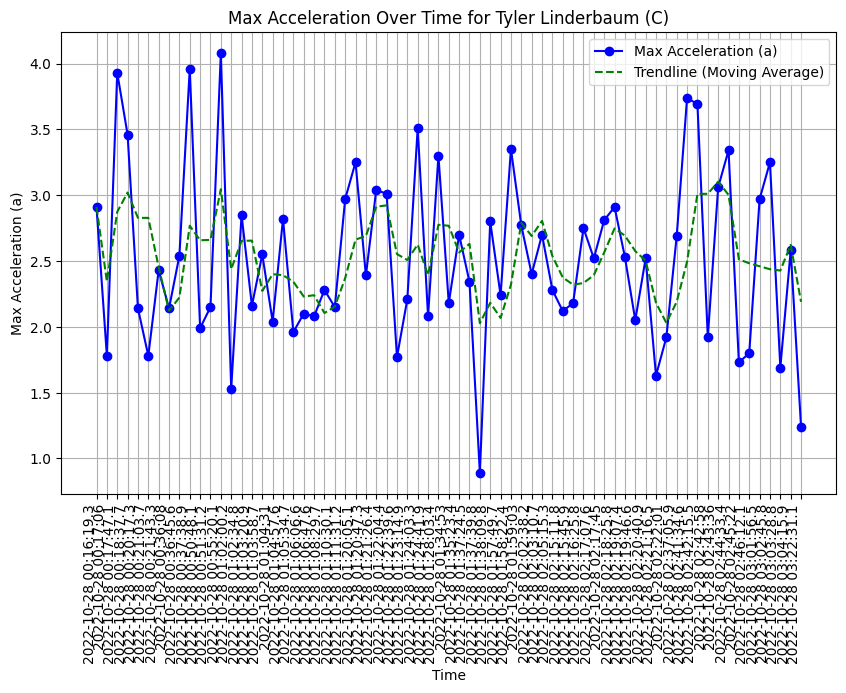

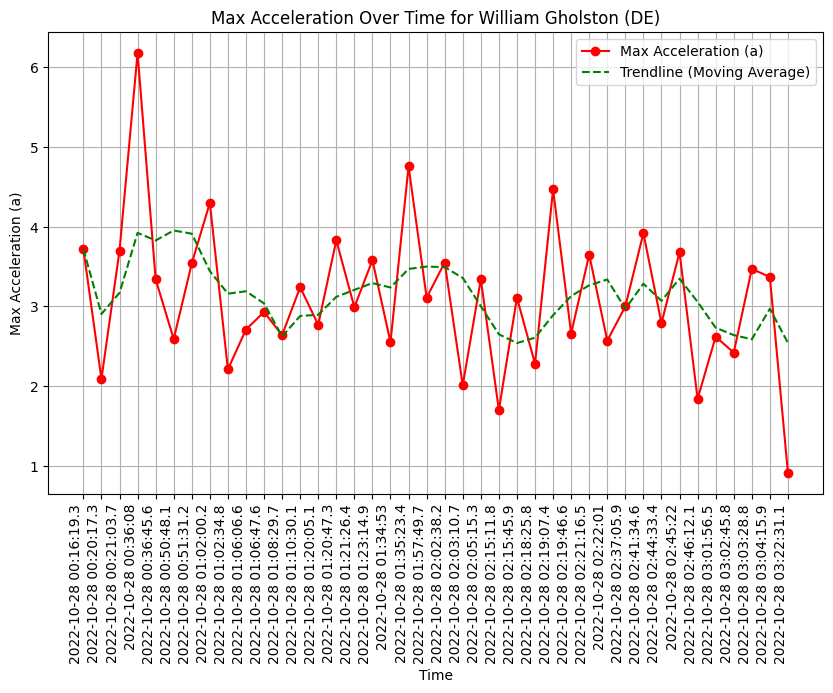

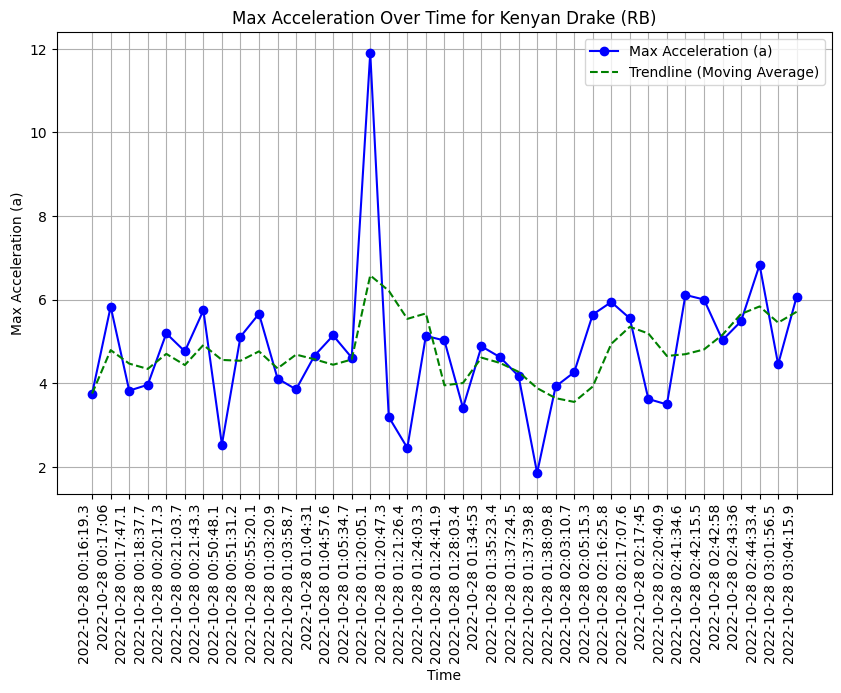

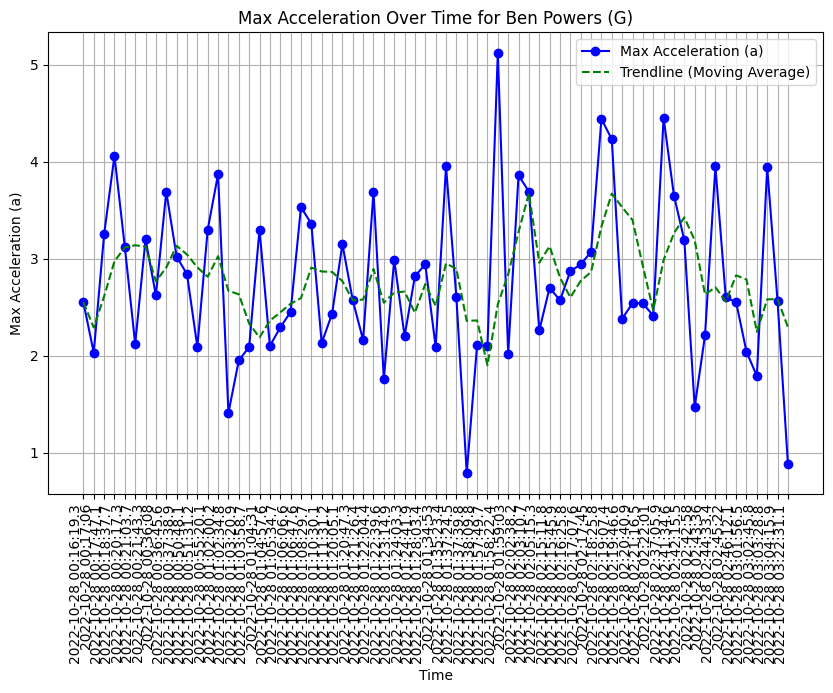

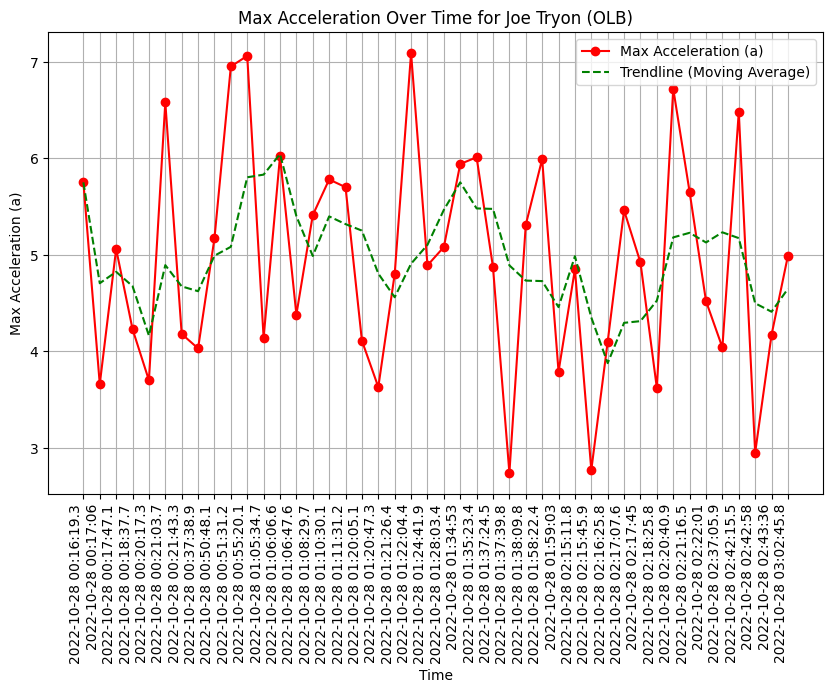

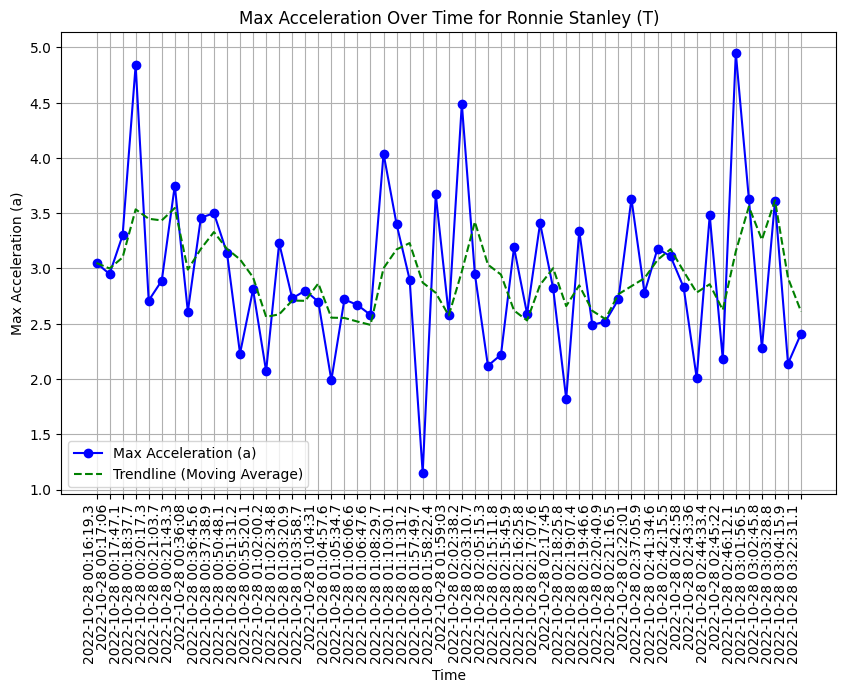

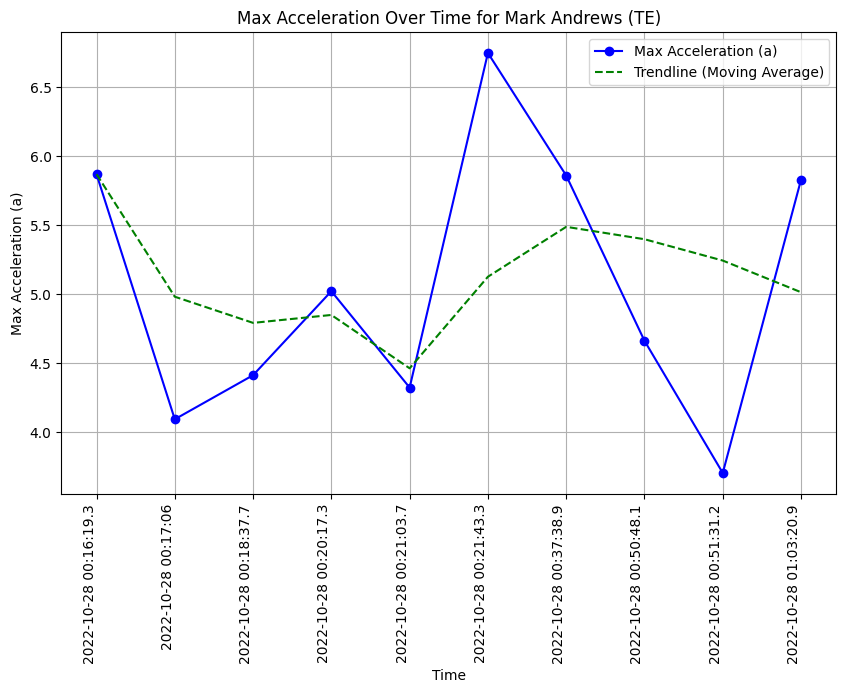

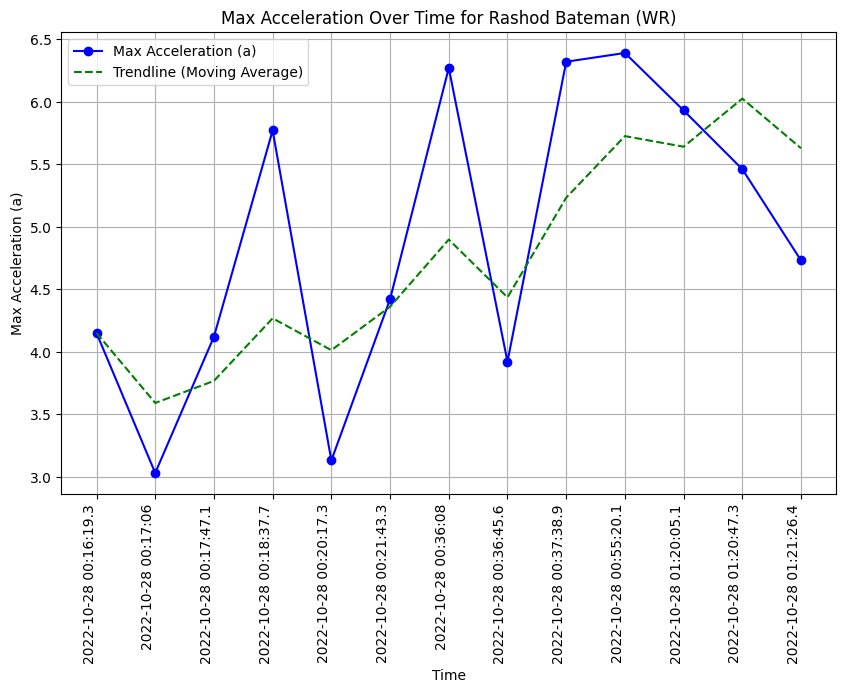

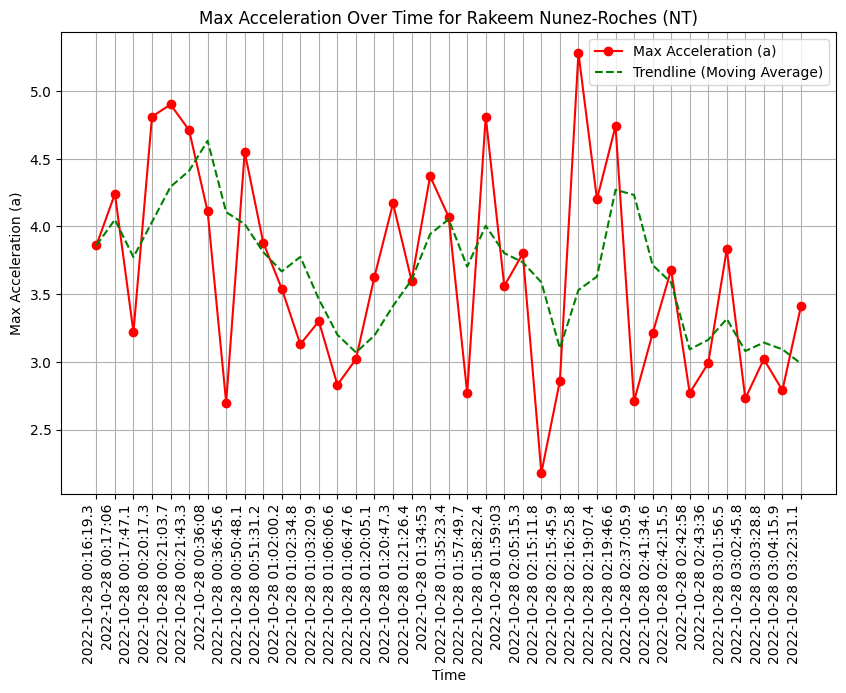

C:\Users\YOUNGRI\AppData\Local\Temp\ipykernel_13820\3929160605.py:35: UserWarning: Comparisons with None always result in null. Consider using `.is_null()` or `.is_not_null()`.
  (pl.col("nflId") == single_player['nflId'].first())


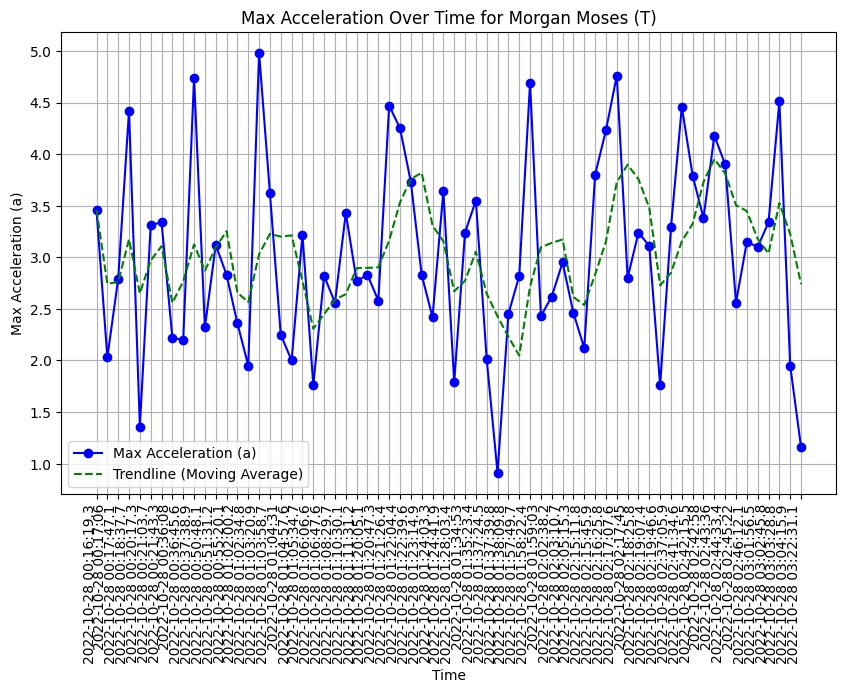

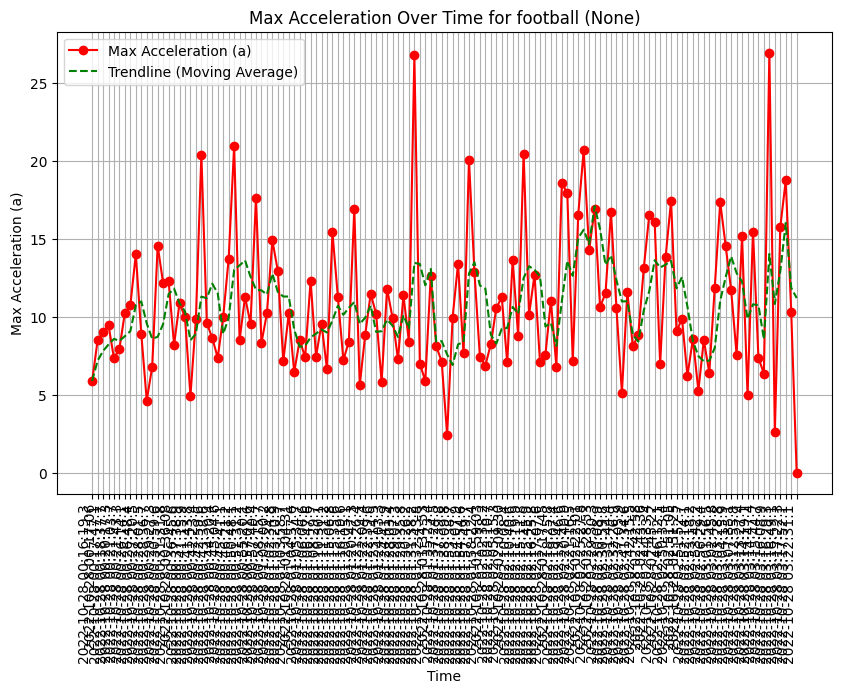

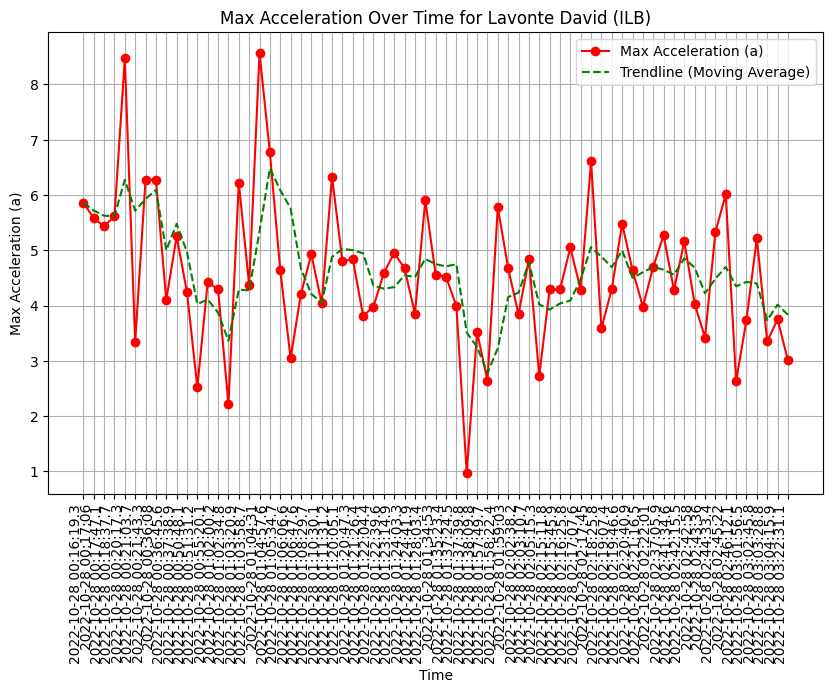

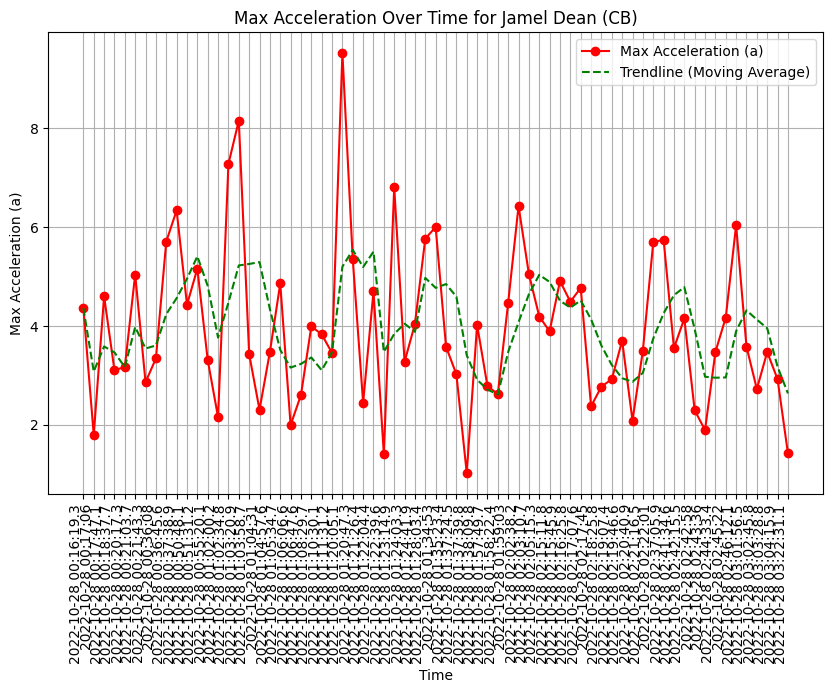

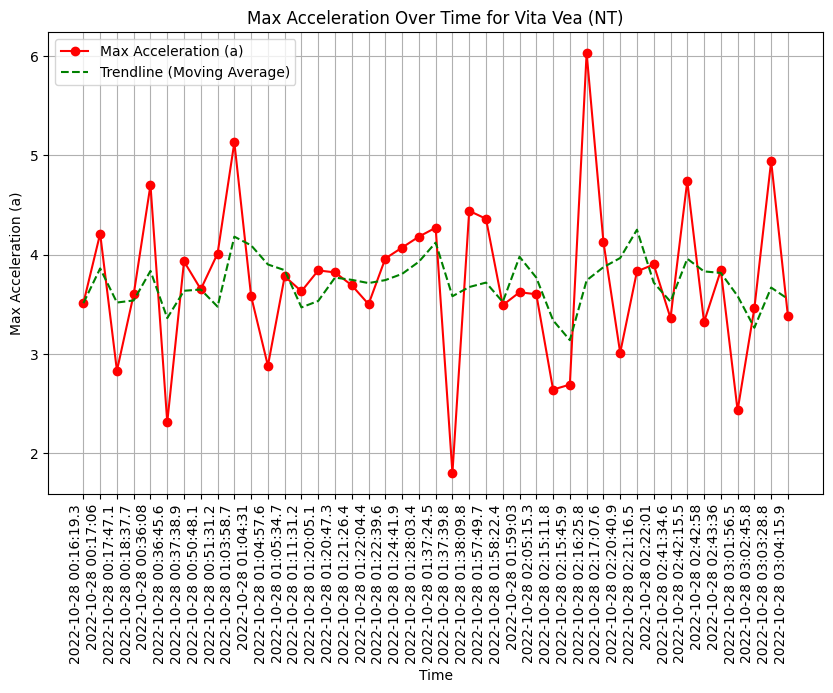

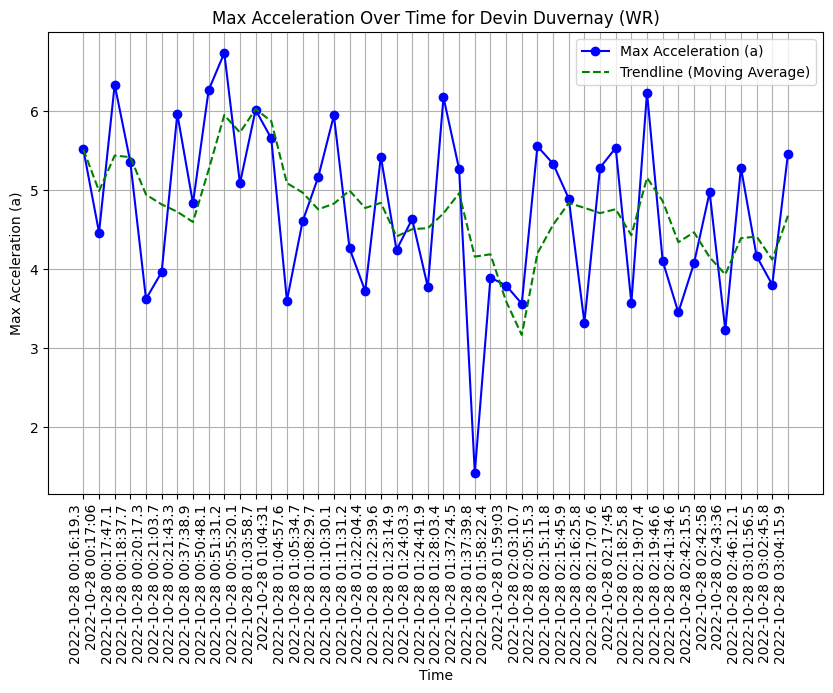

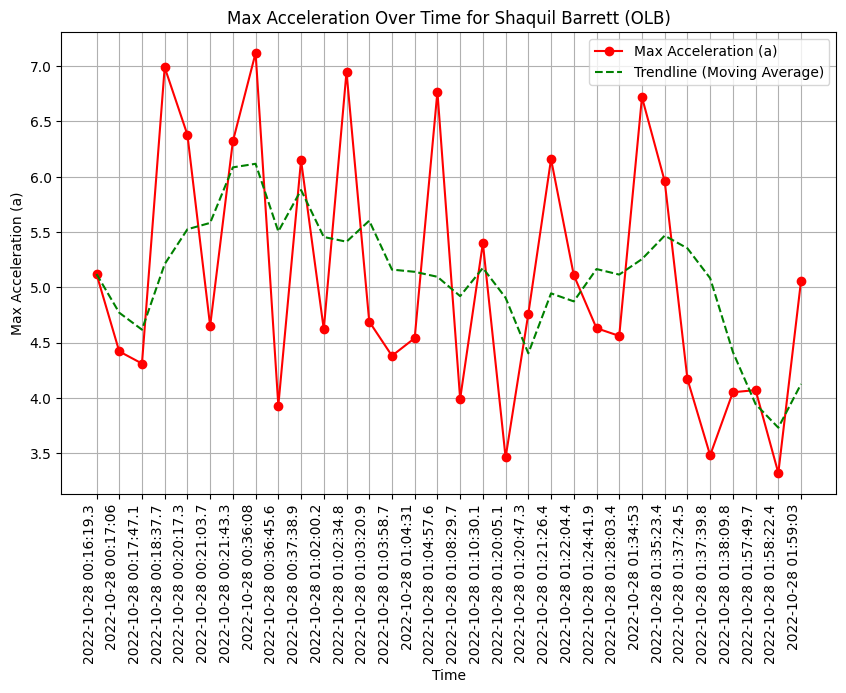

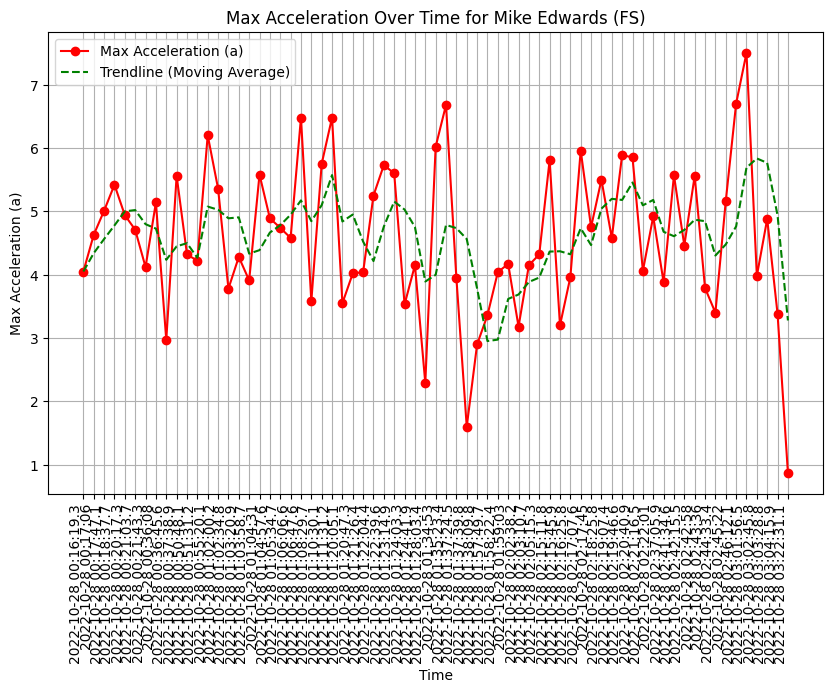

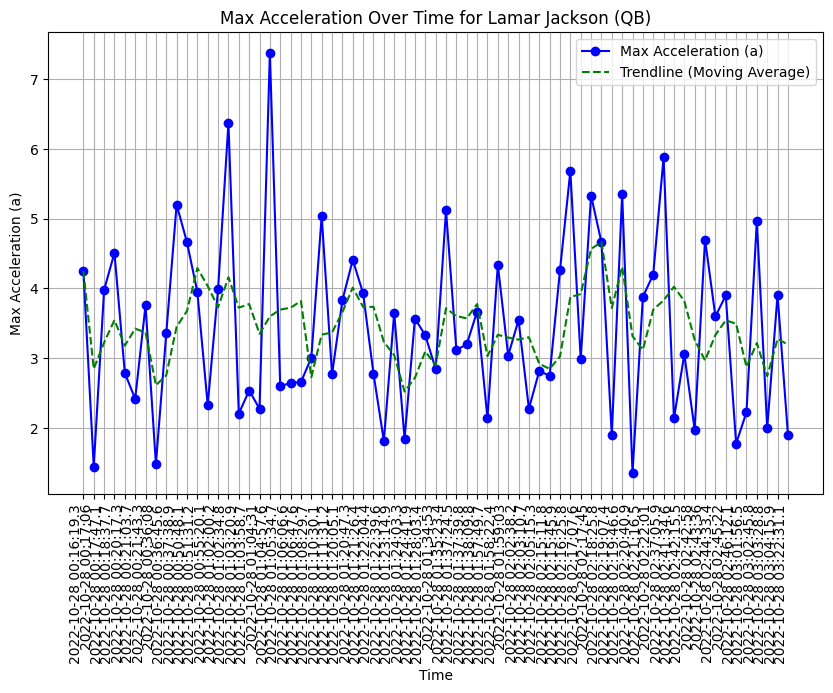

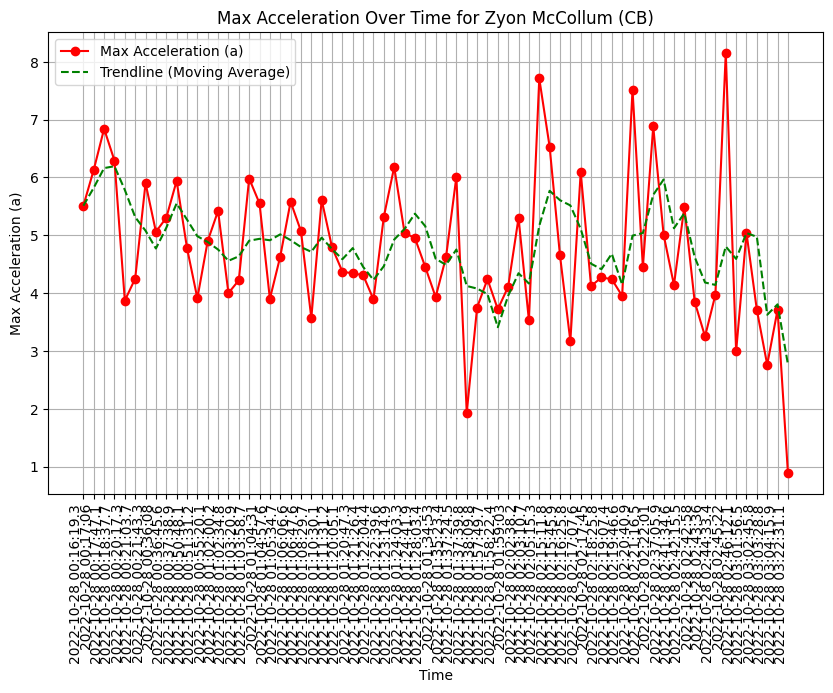

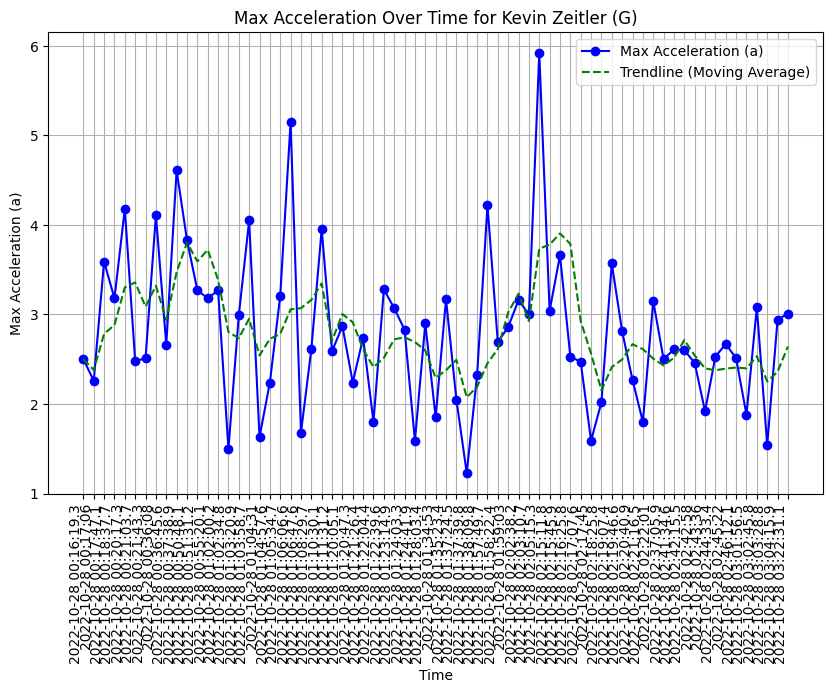

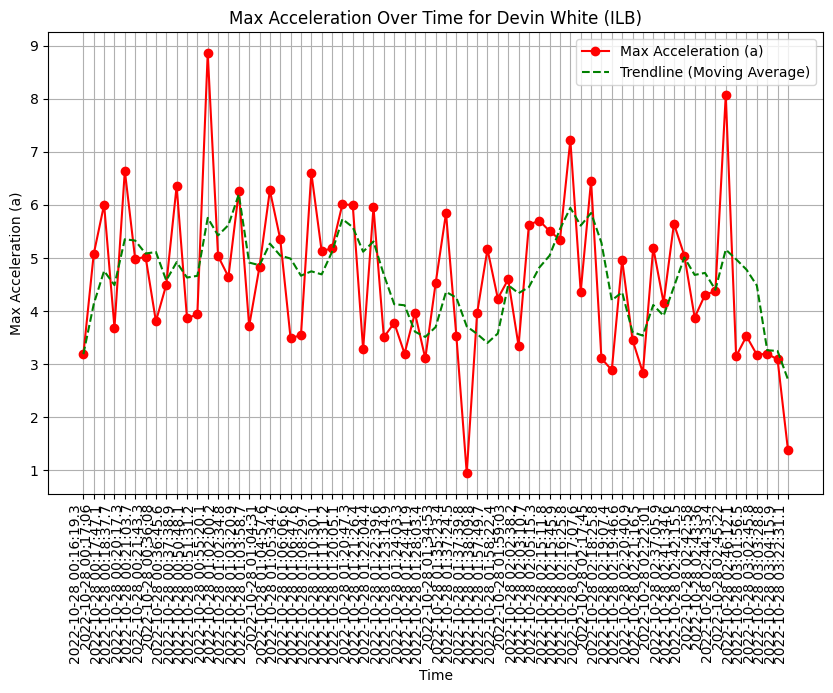

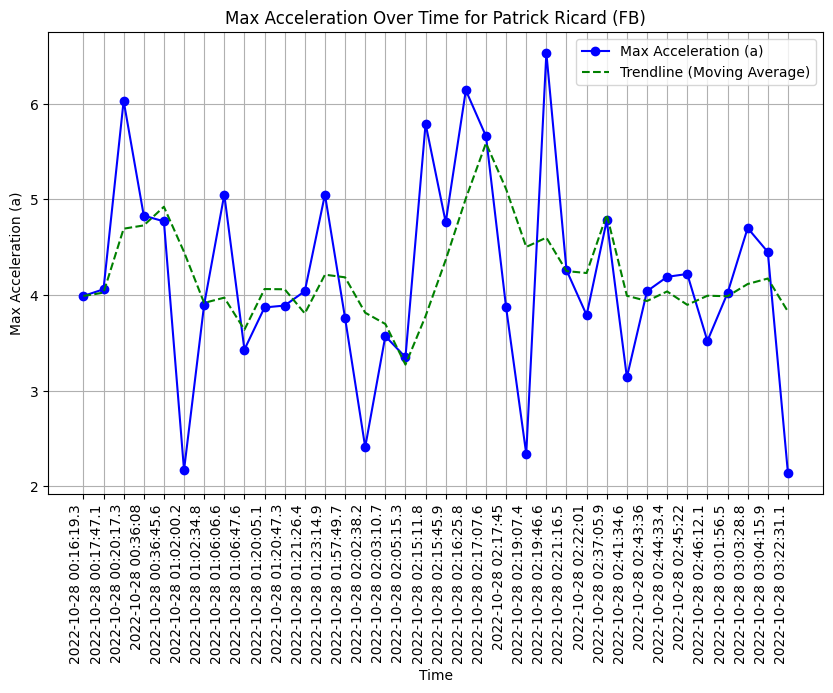

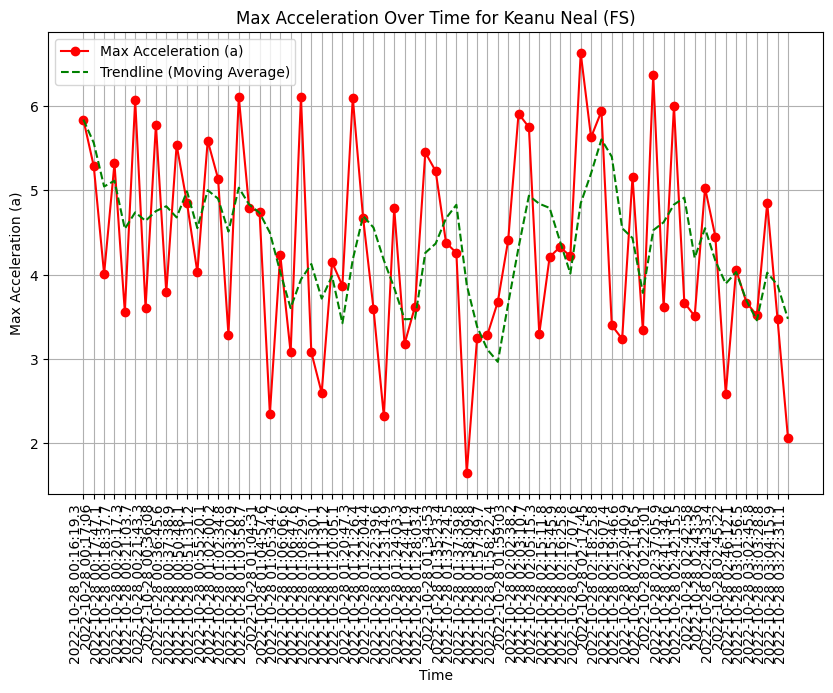

In [200]:
offensive_positions = ["QB", "RB", "T", "FB", "G", "C", "WR", "TE"]
show = ["DE", "ILB", "NT", "OLB"]
for p in first_play['displayName'].unique():
    single_player = test_game.filter(
        (pl.col("displayName") == p)    
    )
    single_player = single_player.join(plays, on= ["playId"])
    grouped_data = single_player.group_by("playId", maintain_order=True).agg(
        pl.col("a").max().alias("max_a"),
        pl.col("time").first().alias("time"),
        pl.col("displayName").first(),
        pl.col("quarter").first()
    )

    grouped_data = grouped_data.sort("time")
    grouped_data = grouped_data.with_columns(
        pl.arange(0, grouped_data.height, eager=True).alias("play")
    )
    grouped_data = grouped_data.with_columns(
        (
            (pl.col("quarter").cast(pl.Utf8) + "." + pl.col("play").cast(pl.Utf8))
            .cast(pl.Float64)
        ).alias("quarter_play")
    )
    # Calculate the rolling mean using Polars
    window_size = 4  # Adjust the window size for smoothing
    grouped_data = grouped_data.with_columns(
        pl.col("max_a").rolling_mean(window_size, min_periods=1).alias("moving_avg")
    )

    # Convert time to string for proper plotting
    time_strings = grouped_data["time"].to_list()

    pos = players.filter(
        (pl.col("nflId") == single_player['nflId'].first())
    )

    player_position =str(pos['position'].first())

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(time_strings, grouped_data["max_a"], marker='o', linestyle='-', color='blue' if player_position in offensive_positions else 'red', label="Max Acceleration (a)")
    
    # Add the trendline
    plt.plot(time_strings, grouped_data["moving_avg"], linestyle='--', color='green', label="Trendline (Moving Average)")
    
    plt.title(f"Max Acceleration Over Time for {grouped_data['displayName'][0]} ({player_position})")
    plt.xlabel("Time")
    plt.xticks(rotation=90, ha='right')
    plt.ylabel("Max Acceleration (a)")
    plt.legend()
    plt.grid(True)
    if player_position in show:
        plt.show()
    else:
        continue

How can we apply Newtonian Physics to the pass rush?

For starters, Newton's second law states that the force applied to an object is equal to the object's mass multiplied by its acceleration -- mesaured in Newtons.